# Postprocessing

In [1]:
import os
import re
import glob
import csv
import sys
import shutil
import numpy as np
import pandas as pd
from collections import Counter

In [2]:
sys.path.insert(0, "./results/python")
import background as bg

In [3]:
from matplotlib import pyplot as plt

In [4]:
goodinput = ['yes', 'y', 'Y', 'Yes']
noinput = ['no', 'n', 'N', 'No']
discardinput = ['discard', 'd', 'D']
retryinput = ['retry', 'r', 'R']
manualmode = ['manual', 'm', 'M']
numaxmode = ['numax', 'n', 'N']

In [5]:
# Read in previous assessments
previousstars = {}
with open("Summarise.csv") as fp:
    #print(fp.read())
    rows = list(csv.DictReader(fp, delimiter='\t'))
    for row in rows:
        previousstars[row['star']] = row

In [8]:
def read_initialnumax(numaxguessfiles):
    # Read in list of initial guesses of numax from manual inspection
    starlists = []

    stars = {}
    for numaxguessfile in numaxguessfiles:
        if 'reftable' in numaxguessfile.split('/')[0]:
            print('Estimate numax')
            numaxlist = pd.read_csv(numaxguessfile,
                                skiprows=1,
                                usecols=[0, 1],
                                names=['ID', 'numax'],
                                dtype={'ID': str, 'numax': np.float64},
                                delim_whitespace=True)
        else:
            numaxlist = pd.read_csv(numaxguessfile,
                                skiprows=2,
                                usecols=[0, 1],
                                names=['ID', 'numax'],
                                dtype={'ID': str, 'numax': np.float64},
                                delim_whitespace=True)
        for row in range(len(numaxlist)):
            starid = numaxlist['ID'][row]
            starid = 'CRT%010d' % int(starid)
            stars.setdefault(starid, {"initialnumax": {}})
            stars[starid].setdefault('runs', {})
            stars[starid].setdefault('numax', [])
            #assert numaxguessfile not in stars[starid]["initialnumax"]
            numax = float(numaxlist['numax'][row])
            stars[starid]["initialnumax"][numaxguessfile] = numax
    return stars


def get_param_names(model_name):
    # plot_labels = [r'W [ppm$^2$/$\mu$Hz]',
    #                r'$\sigma_{color}$ [ppm]',
    #                r'$\nu_{color}$ [$\mu$Hz]',
    #                r'$\sigma_{long}$ [ppm]',
    #                r'$\nu_{long}$ [$\mu$Hz]',
    #                r'$\sigma_{gran,1}$ [ppm]',
    #                r'$\nu_{gran,1}$ [$\mu$Hz]',
    #                r'$\sigma_{gran,2}$ [ppm]',
    #                r'$\nu_{gran,2}$ [$\mu$Hz]',
    #                r'$\sigma_{gran}^{org}$ [ppm]',
    #                r'$\nu_{gran}^{org}$ [$\mu$Hz]',
    #                r'H$_{osc}$ [ppm$^2$/$\mu$Hz]',
    #                r'$\nu_{max}$ [$\mu$Hz]',
    #                r'$\sigma_{env}$ [$\mu$Hz]']
    names = [
        'w',
        'stdcolor',
        'nucolor',
        'stdlong',
        'nulong',
        'stdgran1',
        'nugran1',
        'stdgran2',
        'nugran2',
        'stdgran',
        'nugran',
        'hosc',
        'numax',
        'stdenv',
    ]

    model_col_names = {
        'FlatNoGaussian': [names[0]],
        'Flat': [names[0]] + names[-3:],
        'Original': [names[0]] + names[9:11] + names[-3:],
        'OneHarveyNoGaussian': [names[0]] + names[7:9],
        'OneHarvey': [names[0]] + names[7:9] + names[-3:],
        'OneHarveyColor': names[0:3] + names[7:9] + names[-3:],
        'TwoHarveyNoGaussian': [names[0]] + names[5:9],
        'TwoHarvey': [names[0]] + names[5:9] + names[-3:],
        'TwoHarveyColor': names[0:3] + names[5:9] + names[-3:],
        'ThreeHarveyNoGaussian': [names[0]] + names[3:9],
        'ThreeHarvey': [names[0]] + names[3:9] + names[-3:],
        'ThreeHarveyColor': [names[0:9]] + names[-3:],
    }
    return model_col_names[model_name]


def get_params(starid, run, newest=False):
    if not isinstance(run, str):
        run = str(run)
        
    if newest:
        resultfile = max(glob.glob(
            os.path.join('./results/', starid, '*/background_parameterSummary.txt')
        ))
    else:
        resultfile = os.path.join('./results', starid, run, 'background_parameterSummary.txt')

    if not os.path.exists(resultfile):
        return None
    sumfile = np.loadtxt(resultfile, skiprows=11)
    if sumfile.shape[0] == 6:
        param_names = get_param_names("OneHarvey")
    elif sumfile.shape[0] == 8:
        param_names = get_param_names("TwoHarvey")
    else:
        raise Exception((sumfile.shape, resultfile))
    colnames = ["mean", "median", "mode", "var", "lo", "hi", "skew"]
    assert sumfile.shape == (len(param_names), len(colnames)), sumfile.shape
    return {
        param_name: {
            colname: v
            for colname, v in zip(colnames, row)
        }
        for param_name, row in zip(param_names, sumfile.tolist())
    }
# Column #1: I Moment (Mean)
# Column #2: Median
# Column #3: Mode
# Column #4: II Moment (Variance if Normal distribution)
# Column #5: Lower Credible Limit
# Column #6: Upper Credible Limit
# Column #7: Skewness (Asymmetry of the distribution, -1 to the left, +1 to the right, 0 if symmetric)


def get_numax2(starid, run, newest=False):
    x = get_params(starid, run, newest)
    return x['numax']['mode']


def get_numax(starid, run, newest=False):
    if not isinstance(run, str):
        run = str(run)
        
    if newest:
        resultfile = max(glob.glob(
            os.path.join('./results/', starid, '*/background_parameterSummary.txt')
        ))
    else:
        resultfile = os.path.join('./results', starid, run, 'background_parameterSummary.txt')
        
    if os.path.exists(resultfile):
        sumfile = np.loadtxt(resultfile, skiprows=11)
        if sumfile.shape[0] == 6:
            # OneHarvey
            return sumfile[4][2]
        if sumfile.shape[0] == 8:
            # TwoHarvey
            return sumfile[6][2]
        raise Exception((sumfile.shape, resultfile))
    else:
        return None

    
def get_finalnumax(starid):
    resultfile = max(glob.glob(
        os.path.join('./results/', starid, '*/background_parameterSummary.txt')
    ))
    sumfile = np.loadtxt(resultfile, skiprows=11)
    if sumfile.shape[0] == 6:
        # OneHarvey
        return sumfile[4][2]
    if sumfile.shape[0] == 8:
        # TwoHarvey
        return sumfile[6][2]
    raise Exception((sumfile.shape, resultfile))

    
def read_logs(stars, run, idstr):
    # Changed from Summarise
    # Check newest logfile only
    # If success:
    # Save numax
    # If no success but success in other logfile
    # Get numax from there
    missing = []
    if not isinstance(run, str):
        run = str(run)
    idstr = idstr + 'run_' + run
    logfiles = sorted(glob.glob('./evaluation/*' + idstr + '*.csv'))
    assert logfiles
    for logfile in logfiles:
        with open(logfile) as fp:
            rows = list(csv.DictReader(fp, delimiter='\t'))
        for row in rows:
            starid = row['star']
            if starid not in stars:
                missing.append(starid)
                continue
            assert starid in stars, starid
            
            stars[starid]['runs'][run] = {}
            stars[starid]['runs'][run]["decision"] = row["decision"]
            stars[starid]['runs'][run]['good'] = False

            if row['oc_std'] == '':
                continue
            params = get_params(starid, run)
            # nm = get_numax(starid, run)
            if params is None:
                stars[starid]['numax'].append(np.nan)
                continue
            nm = params['numax']['mode']
            stars[starid]['numax'].append(nm)
            stars[starid]['runs'][run]['numax'] = nm
            stars[starid]['runs'][run]['params'] = params
            stars[starid]['runs'][run]['oc_std'] = row['oc_std']
            stars[starid]['runs'][run]['good'] = True
            #stars[starid]['finalnumax'] = get_numax_cache[starid]
            if row['notes'] is not None:
                stars[starid]['runs'][run]['notes'] = row['notes']
    print('Number of missing stars:', len(missing))
    print(missing)

    
def runcase(idstr, runs, numaxguessfiles):
    stars = read_initialnumax(numaxguessfiles)
    print('Number of stars', len(stars.keys()))
    
    # Read logfiles
    for run in runs:
        print(run)
        read_logs(stars, run=run, idstr=idstr)
        print(len(stars.keys()))

    for starid in stars.keys():
        stars[starid]['previousnumax'] = 0
        if starid in previousstars.keys():
            if previousstars[starid]['finalnumax'] != '':
                stars[starid]['previousnumax'] = float(previousstars[starid]['finalnumax'])
                stars[starid]['previousnotes'] = previousstars[starid]['notes']
    return stars

In [9]:
psdstarsrr = runcase(
    idstr='corot_psd',
    runs=[11, 12, 13, 14],
    numaxguessfiles= [
    'projects/corot/jan2022/Runs_20220124PSD/CoRoT_COR_C01R_G1.txt',
    ])

psdstars = runcase(
    idstr='corot_psd',
    runs=[11, 12],
    numaxguessfiles= [
'projects/corot/jan2022/Runs_20220124PSD/CoRoT_COR_C01R_G1.txt',
])

lcstarsrr = runcase(
    idstr='corot_lc',
    runs=[21, 22, 23, 24],
    numaxguessfiles=[
'projects/corot/jan2022/Runs_20220124LC/CoRoT_COR_C01_G1.txt',
])

lcstars = runcase(
    idstr='corot_lc',
    runs=[21, 22],
    numaxguessfiles=[
'projects/corot/jan2022/Runs_20220124LC/CoRoT_COR_C01_G1.txt',
])

Number of stars 2676
11
Number of missing stars: 0
[]
2676
12
Number of missing stars: 0
[]
2676
13
Number of missing stars: 0
[]
2676
14
Number of missing stars: 0
[]
2676
Number of stars 2676
11
Number of missing stars: 0
[]
2676
12
Number of missing stars: 0
[]
2676
Number of stars 3239
21
Number of missing stars: 0
[]
3239
22
Number of missing stars: 0
[]
3239
23
Number of missing stars: 0
[]
3239
24
Number of missing stars: 0
[]
3239
Number of stars 3239
21
Number of missing stars: 0
[]
3239
22
Number of missing stars: 0
[]
3239


In [10]:
blindstars = runcase(
    idstr='corotblind',
    runs=[41, 42],
    numaxguessfiles=[
        'projects/corot/estimatenumax/reftable.txt',
    ]
)

Number of stars 69138
41
Number of missing stars: 29
['CRT0101364299', 'CRT0101549538', 'CRT0101071707', 'CRT0101157705', 'CRT0101329423', 'CRT0100911589', 'CRT0101049417', 'CRT0101196955', 'CRT0101422060', 'CRT0101342052', 'CRT0101254050', 'CRT0100840156', 'CRT0100878866', 'CRT0100850823', 'CRT0100881260', 'CRT0101069502', 'CRT0100908867', 'CRT0101125713', 'CRT0101270303', 'CRT0101015866', 'CRT0101507943', 'CRT0101256787', 'CRT0101352770', 'CRT0101324942', 'CRT0101578716', 'CRT0101254412', 'CRT0101441338', 'CRT0101065855', 'CRT0101095770']
69138
42
Number of missing stars: 29
['CRT0101364299', 'CRT0101549538', 'CRT0101071707', 'CRT0101157705', 'CRT0101329423', 'CRT0100911589', 'CRT0101049417', 'CRT0101196955', 'CRT0101422060', 'CRT0101342052', 'CRT0101254050', 'CRT0100840156', 'CRT0100878866', 'CRT0100850823', 'CRT0100881260', 'CRT0101069502', 'CRT0100908867', 'CRT0101125713', 'CRT0101270303', 'CRT0101015866', 'CRT0101507943', 'CRT0101256787', 'CRT0101352770', 'CRT0101324942', 'CRT010

# Check results

In [106]:
lcstars['CRT0100402467']["runs"][list(lcstars['CRT0100402467']["runs"].keys())[-1]]['numax']

15.02272891

In [85]:
# Q: Did the refinement work? Does it mostly have the latest run if multiple runs?
# If so, the latest version of numax should be from the newest run (and not have disappered from the first)
def histcompare(stars):
    a = [list(lcstars[starid]['runs'].keys())[-1] for starid in lcstars.keys()
         for b in list(lcstars[starid]['runs'].values()) if 'numax' in b]
    letter_counts = Counter(a)
    df = pd.DataFrame.from_dict(letter_counts, orient='index')
    df.plot(kind='bar', legend=False)
    plt.xlabel('Run')
    plt.ylabel('Counts')
    print(df.nunique)
    # A: Yes it seems to work

In [88]:
# Stars in both runs
def bothruns(stars, check):
    multiplenumax = 
    print('%i stars out of %i have results from more than 1 run' % (
        len([starid for starid in stars.keys() for b in list(lcstars[starid]['runs'].values()) if 'numax' in b]), len(stars)))
    # Q: How does the numax from the first run compare to the second?
    nu1 = np.asarray([stars[starid]['numax'] for starid in stars.keys()
                      for b in list(lcstars[starid]['runs'].values()) if 'numax' in b]).astype(float)
    nu2 = np.asarray([stars[starid]['numax'] for starid in stars.keys()
                      for b in list(lcstars[starid]['runs'].values()) if 'numax' in b]).astype(float)

    diff = nu2 - nu1
    plt.figure()
    plt.scatter(nu2, diff, s=2)
    plt.xlabel('Newest numax')
    plt.ylabel('Newest-oldest numax')
    # Typically nu1 > nu2

    # Q: How does the numax from the second run compare to the initial values?
    inu = np.asarray([np.fromiter(stars[starid]['initialnumax'].values(), dtype=float)[0]
                      for starid in stars.keys() 
                      for b in list(lcstars[starid]['runs'].values()) if 'numax' in b]).astype(float)
    diff = nu2 - inu
    plt.figure()
    plt.scatter(nu2, diff, s=2)
    plt.xlabel('Newest numax')
    plt.ylabel('Newest-oldest numax')
    # A: Similar to nu1 vs nu2. Probably as initial values are close (or border) values

    # Q: How does the numax from the second run compare to the numax from old runs?
    pnu = np.asarray([stars[starid]['previousnumax'] for starid in stars.keys()
                      if (stars[starid]['previousnumax'] != 0)
                      for b in list(lcstars[starid]['runs'].values()) if 'numax' in b]).astype(float)
    pnu2 = np.asarray([stars[starid]['numax'][1] for starid in stars.keys()
                       if (stars[starid]['previousnumax'] != 0)
                       for b in list(lcstars[starid]['runs'].values()) if 'numax' in b]).astype(float)
    diff = pnu2 - pnu
    plt.figure()
    plt.scatter(pnu2, diff, s=2)
    plt.xlabel('Newest numax')
    plt.ylabel('Newest-oldest numax')

    sids = np.asarray([starid for starid in stars.keys()
                       if (stars[starid]['previousnumax'] != 0)
                       for b in list(lcstars[starid]['runs'].values()) if 'numax' in b]).astype(str)
    th = 10
    check.extend(sids[np.abs(diff) > th])
    print('%i stars have a difference between old and new runs of more than %i' % (
        len(sids[np.abs(diff) > th]), th))
    print(sids[np.abs(diff) > th])
    print(pnu[np.abs(diff) > th])
    print(pnu2[np.abs(diff) > th])
    plt.scatter(pnu2[np.abs(diff) > th], diff[np.abs(diff) > th], s=2, c='r')


In [12]:
# Q: How does any star with numax compare to the initial numax guess?
def numaxvsguess(stars):
    nu1 = np.asarray([np.fromiter(stars[starid]['initialnumax'].values(), dtype=float)[0] for starid in stars.keys() if len(stars[starid]['numax']) > 0]).astype(float)
    nu2 = np.asarray([stars[starid]['numax'][-1] for starid in stars.keys() if len(stars[starid]['numax']) > 0]).astype(float)
    nu3 = np.asarray([np.fromiter(stars[starid]['initialnumax'].values(), dtype=float)[0] for starid in stars.keys() if len(stars[starid]['numax']) > 1]).astype(float)
    nu4 = np.asarray([stars[starid]['numax'][-1] for starid in stars.keys() if len(stars[starid]['numax']) > 1]).astype(float)
    print(len(nu1))

    diff = nu2 - nu1
    diff2 = nu4 - nu3

    plt.figure()
    plt.scatter(nu1, diff, s=2)
    plt.scatter(nu3, diff2, s=2, c='r')

    plt.xlabel('Newest numax')
    plt.ylabel('Newest-initial numax')
    # Typically nu1 > nu2


    plt.figure()
    plt.scatter(nu1[~np.isin(nu1, nu3)], diff[~np.isin(nu1, nu3)], s=2)
    plt.xlabel('Newest numax, only 1 run')
    plt.ylabel('Newest-initial numax')

In [83]:
# Q: How does the previous results compare to the new intial numax values?
def previousvsinitial(stars, check):
    nu1 = np.asarray([np.fromiter(stars[starid]['initialnumax'].values(), dtype=float)[0] for starid in stars.keys() if (stars[starid]['previousnumax'] != 0)]).astype(float)
    nu2 = np.asarray([stars[starid]['previousnumax'] for starid in stars.keys() if (stars[starid]['previousnumax'] != 0)]).astype(float)

    diff = nu2 - nu1
    plt.figure()
    plt.scatter(nu1, diff, s=2)
    plt.xlabel('Previous runs numax')
    plt.ylabel('Previous runs-initial guess numax')

    sids = np.asarray([starid for starid in stars.keys() if (str(stars[starid]['previousnumax']) != '[]')]).astype(str)
    th = 10
    check.extend(sids[np.abs(diff) > th])
    print('%i stars have a difference between previous results and new initial numax of more than %i' % (len(sids[np.abs(diff) > th]), th))
    print(sids[np.abs(diff) > th])
    print(nu1[np.abs(diff) > th])
    print(nu2[np.abs(diff) > th])
    plt.scatter(nu1[np.abs(diff) > th], diff[np.abs(diff) > th], s=2, c='r')


# Check results for LC

In [92]:
lcstars

{'CRT0100402467': {'initialnumax': {'projects/corot/jan2022/Runs_20220124LC/CoRoT_COR_C01_G1.txt': 19.88},
  'runs': {'21': {'decision': 'retry', 'good': False},
   '22': {'decision': 'retry',
    'good': True,
    'numax': 15.02272891,
    'oc_std': '7648.088365222782',
    'notes': 'None'}},
  'numax': [15.02272891],
  'previousnumax': 19.96853198,
  'previousnotes': 'None'},
 'CRT0100408489': {'initialnumax': {'projects/corot/jan2022/Runs_20220124LC/CoRoT_COR_C01_G1.txt': 3.55},
  'runs': {'21': {'decision': 'retry', 'good': False},
   '22': {'decision': 'retry', 'good': False}},
  'numax': [],
  'previousnumax': 0},
 'CRT0100411979': {'initialnumax': {'projects/corot/jan2022/Runs_20220124LC/CoRoT_COR_C01_G1.txt': 30.55},
  'runs': {'21': {'decision': 'retry',
    'good': True,
    'numax': 30.94284202,
    'oc_std': '6754.20358304578',
    'notes': 'None'},
   '22': {'decision': 'retry',
    'good': True,
    'numax': 28.62447737,
    'oc_std': '6018.595615575193',
    'notes': 'No

<bound method DataFrame.nunique of        0
22  3491>


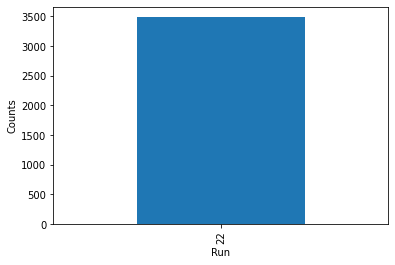

In [107]:
# Q: Did the refinement work? Does it mostly have the latest run if multiple runs?
# If so, the latest version of numax should be from the newest run (and not have disappered from the first)
histcompare(lcstars)
# A: Yes it seems to work, all newest are from 22

In [89]:
# Stars in both runs
lccheck = []
bothruns(lcstars, lccheck)
# Q: How does the numax from the first run compare to the second?
# Typically nu1 > nu2

# Q: How does the numax from the second run compare to the initial values
# A: Similar to nu1 vs nu2. Probably as initial values are close (or border) values

3491 stars out of 3239 have results from more than 1 run


/home/amalie/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


ValueError: setting an array element with a sequence.

2175


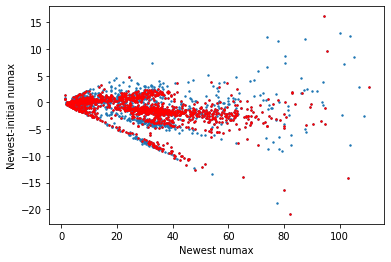

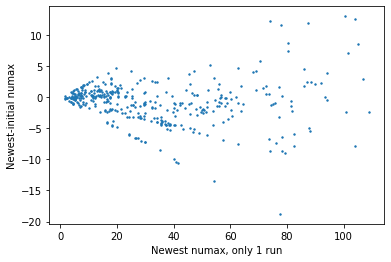

In [75]:
# Q: How does any star with numax compare to the initial numax guess?
# Typically nu1 > nu2
numaxvsguess(lcstars)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 3239 but corresponding boolean dimension is 1925

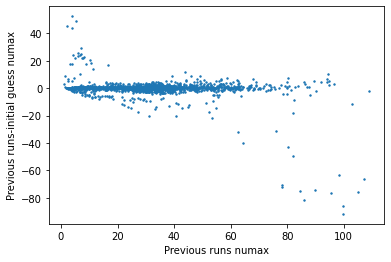

In [84]:
# Q: How does the previous results compare to the new intial numax values?
previousvsinitial(lcstars, lccheck)

In [38]:
print('Please check the following %s stars manually' % len(np.unique(np.array(lccheck))))
print(np.unique(np.array(lccheck)))
print('These will be removed from the excludelist')

Please check the following 73 stars manually
['CRT0100556225' 'CRT0100562083' 'CRT0100633636' 'CRT0100667742'
 'CRT0100679514' 'CRT0100683127' 'CRT0100711355' 'CRT0100802960'
 'CRT0100817268' 'CRT0100836087' 'CRT0100853482' 'CRT0100868899'
 'CRT0100880037' 'CRT0100884223' 'CRT0100892975' 'CRT0100932827'
 'CRT0100936353' 'CRT0100944341' 'CRT0100946490' 'CRT0100980762'
 'CRT0100988656' 'CRT0101001054' 'CRT0101019972' 'CRT0101023082'
 'CRT0101034881' 'CRT0101037205' 'CRT0101038364' 'CRT0101047814'
 'CRT0101059748' 'CRT0101071572' 'CRT0101084795' 'CRT0101112682'
 'CRT0101113010' 'CRT0101119515' 'CRT0101124366' 'CRT0101146533'
 'CRT0101152878' 'CRT0101172095' 'CRT0101203536' 'CRT0101226927'
 'CRT0101233022' 'CRT0101234918' 'CRT0101248026' 'CRT0101252250'
 'CRT0101268072' 'CRT0101276969' 'CRT0101287885' 'CRT0101295614'
 'CRT0101305188' 'CRT0101313101' 'CRT0101319457' 'CRT0101319910'
 'CRT0101326221' 'CRT0101327362' 'CRT0101347447' 'CRT0101369568'
 'CRT0101370283' 'CRT0101403514' 'CRT01014245

# Check results for PSD

In [54]:
psdcheck = []

<bound method DataFrame.nunique of        0
22  3491>


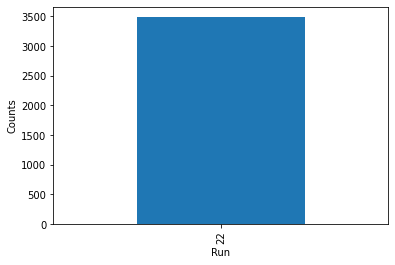

In [109]:
# Q: Did the refinement work? Does it mostly have the latest run if multiple runs?
# If so, the latest version of numax should be from the newest run (and not have disappered from the first)
histcompare(psdstars)
# A: Yes it seems to work, all 12

1033 stars out of 2676 have results from more than 1 run
135 stars have a difference between old and new runs of more than 10
['CRT0100454011' 'CRT0100513356' 'CRT0100551743' 'CRT0100562083'
 'CRT0100624488' 'CRT0100625650' 'CRT0100655964' 'CRT0100657953'
 'CRT0100673590' 'CRT0100678257' 'CRT0100679411' 'CRT0100682488'
 'CRT0100706926' 'CRT0100716817' 'CRT0100717125' 'CRT0100718254'
 'CRT0100743629' 'CRT0100758194' 'CRT0100762143' 'CRT0100768664'
 'CRT0100782155' 'CRT0100795824' 'CRT0100800096' 'CRT0100809477'
 'CRT0100809880' 'CRT0100813059' 'CRT0100861203' 'CRT0100867895'
 'CRT0100883659' 'CRT0100886873' 'CRT0100888152' 'CRT0100888930'
 'CRT0100888944' 'CRT0100900153' 'CRT0100901998' 'CRT0100922068'
 'CRT0100926478' 'CRT0100958533' 'CRT0100980762' 'CRT0100991658'
 'CRT0101000321' 'CRT0101008578' 'CRT0101010512' 'CRT0101011726'
 'CRT0101018056' 'CRT0101018406' 'CRT0101026664' 'CRT0101030947'
 'CRT0101034025' 'CRT0101037205' 'CRT0101046557' 'CRT0101050462'
 'CRT0101051983' 'CRT01010625

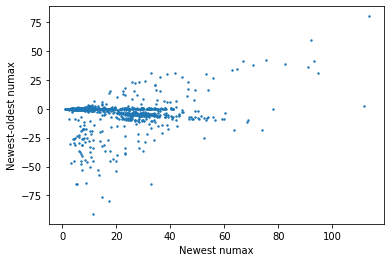

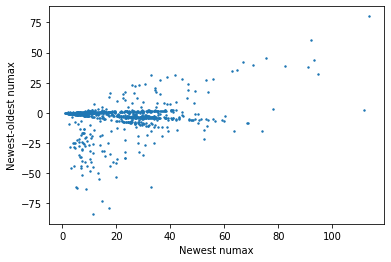

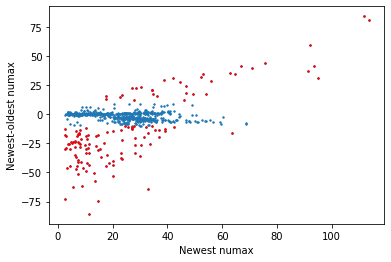

In [59]:
# Stars in both runs
bothruns(psdstars, psdcheck)
# Q: How does the numax from the first run compare to the second?
# Typically nu1 > nu2

# Q: How does the numax from the second run compare to the initial values
# A: Similar to nu1 vs nu2. Probably as initial values are close (or border) values

2232


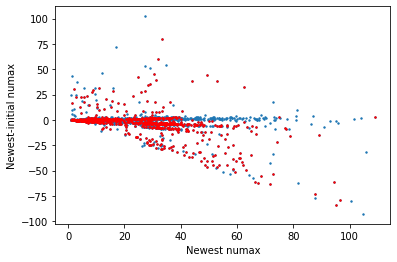

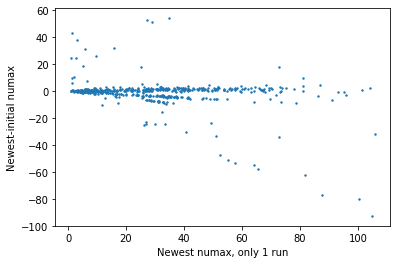

In [60]:
# Q: How does any star with numax compare to the initial numax guess?
# Typically nu1 > nu2
numaxvsguess(psdstars)
# Many more stars are further away from the initial numax guess that the other case

57 stars have a difference between previous results and new initial numax of more than 10
['CRT0100556225' 'CRT0100559061' 'CRT0100605772' 'CRT0100623581'
 'CRT0100679514' 'CRT0100711355' 'CRT0100740782' 'CRT0100802960'
 'CRT0100824689' 'CRT0100836087' 'CRT0100853482' 'CRT0100884223'
 'CRT0100888152' 'CRT0100926822' 'CRT0100932827' 'CRT0100936353'
 'CRT0100985813' 'CRT0101013833' 'CRT0101023082' 'CRT0101039910'
 'CRT0101058398' 'CRT0101070357' 'CRT0101091923' 'CRT0101113010'
 'CRT0101124107' 'CRT0101132240' 'CRT0101159855' 'CRT0101203536'
 'CRT0101233022' 'CRT0101248026' 'CRT0101252250' 'CRT0101268072'
 'CRT0101268257' 'CRT0101271163' 'CRT0101276969' 'CRT0101287885'
 'CRT0101295614' 'CRT0101305188' 'CRT0101312180' 'CRT0101316534'
 'CRT0101337484' 'CRT0101369568' 'CRT0101370283' 'CRT0101398271'
 'CRT0101403514' 'CRT0101432781' 'CRT0101462759' 'CRT0101521561'
 'CRT0101523962' 'CRT0101534497' 'CRT0101539271' 'CRT0101546356'
 'CRT0101550759' 'CRT0101585038' 'CRT0101588604' 'CRT0110568351'


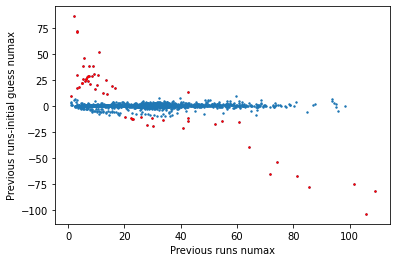

In [57]:
# Q: How does the previous results compare to the new intial numax values?
previousvsinitial(psdstars, psdcheck)

In [61]:
print('Please check the following %s stars manually' % len(np.unique(np.array(lccheck))))
print(np.unique(np.array(psdcheck)))
print('These will be removed from the excludelist')

Please check the following 73 stars manually
['CRT0100454011' 'CRT0100513356' 'CRT0100551743' 'CRT0100556225'
 'CRT0100559061' 'CRT0100562083' 'CRT0100605772' 'CRT0100623581'
 'CRT0100624488' 'CRT0100625650' 'CRT0100655964' 'CRT0100657953'
 'CRT0100673590' 'CRT0100678257' 'CRT0100679411' 'CRT0100679514'
 'CRT0100682488' 'CRT0100706926' 'CRT0100711355' 'CRT0100716817'
 'CRT0100717125' 'CRT0100718254' 'CRT0100740782' 'CRT0100743629'
 'CRT0100758194' 'CRT0100762143' 'CRT0100768664' 'CRT0100782155'
 'CRT0100795824' 'CRT0100800096' 'CRT0100802960' 'CRT0100809477'
 'CRT0100809880' 'CRT0100813059' 'CRT0100824689' 'CRT0100836087'
 'CRT0100853482' 'CRT0100861203' 'CRT0100867895' 'CRT0100883659'
 'CRT0100884223' 'CRT0100886873' 'CRT0100888152' 'CRT0100888930'
 'CRT0100888944' 'CRT0100900153' 'CRT0100901998' 'CRT0100922068'
 'CRT0100926478' 'CRT0100926822' 'CRT0100932827' 'CRT0100936353'
 'CRT0100958533' 'CRT0100980762' 'CRT0100985813' 'CRT0100991658'
 'CRT0101000321' 'CRT0101008578' 'CRT01010105

# Compare LC and PSD

The overlap between stars with results in both cases are 1709


Text(0, 0.5, '$\\nu_{\\mathrm{max,LC}} - \\nu_{\\mathrm{max,PSD}}$')

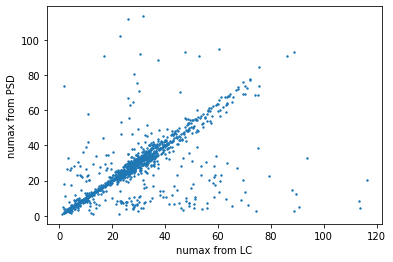

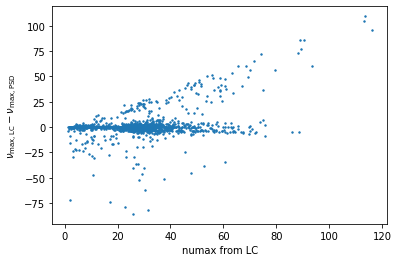

In [10]:
successlc = [starid for starid in lcstars.keys() if len(lcstars[starid]['numax']) > 0]
successlcnumax = [lcstars[starid]['numax'][-1] for starid in lcstars.keys() if len(lcstars[starid]['numax']) > 0]
successpsd = [starid for starid in psdstars.keys() if len(psdstars[starid]['numax']) > 0]
successpsdnumax = [psdstars[starid]['numax'][-1] for starid in psdstars.keys() if len(psdstars[starid]['numax']) > 0]

successcommon = sorted(set(successlc) & set(successpsd))

print('The overlap between stars with results in both cases are', len(successcommon))

plt.figure()
#plt.scatter(np.array(successlcnumax)[np.isin(successlc, successpsd)],
#            np.array(successpsdnumax)[np.isin(successpsd, successlc)], s=2)
lcs = np.asarray([lcstars[s]['numax'][-1] for s in successcommon])
psds = np.asarray([psdstars[s]['numax'][-1] for s in successcommon])
plt.scatter(lcs, psds, s=2)
plt.xlabel('numax from LC')
plt.ylabel('numax from PSD')

for starid in successcommon:
    if lcstars[starid]['numax'][-1] is None or psdstars[starid]['numax'][-1] is None:
        print(starid, lcstars[starid]['numax'][-1], psdstars[starid]['numax'][-1])

    
diff = (lcs - psds)
plt.figure()
plt.scatter(lcs, diff, s=2)
plt.xlabel('numax from LC')
plt.ylabel(r'$\nu_{\mathrm{max,LC}} - \nu_{\mathrm{max,PSD}}$')

# Make excludelist

In [110]:
# In lcrun and psdrun, there are only 2582 (run 22) stars or 2675 (12) stars with data
lcdata = 2583
psddata = 2675

print(len(lcstars.keys()))
print(len(lcstars.keys()) - lcdata)
print(len(psdstars.keys()))
print(len(psdstars.keys()) - psddata)

# Common
print('The two cases have %i stars in common', len(lcstars.keys() & psdstars.keys()))
print('The two cases have %i stars in total', len(lcstars.keys() | psdstars.keys()))

print(len(lcstars.keys() & psdstars.keys()))
print(len(lcstars.keys() | psdstars.keys()))
print(psddata - len(lcstars.keys() & psdstars.keys()))
print(lcdata - len(lcstars.keys() & psdstars.keys()))

print('This number of stars do have initialnumax but no datafile. Maybe they have been removed as they were not RGs')
print(len(lcstars.keys() & psdstars.keys()) -
      (psddata - len(lcstars.keys() & psdstars.keys())) -
      (lcdata - len(lcstars.keys() & psdstars.keys())))

3239
656
2676
1
The two cases have %i stars in common 2119
The two cases have %i stars in total 3796
2119
3796
556
464
This number of stars do have initialnumax but no datafile. Maybe they have been removed as they were not RGs
1099


In [12]:
# What is the number of stars that failed?
nonenumax = [starid for starid in psdstars.keys() if len(psdstars[starid]['numax']) == 0]
print(len(nonenumax))
nonenumax = [starid for starid in lcstars.keys() if len(lcstars[starid]['numax']) == 0]
print(len(nonenumax))


364
1064


In [13]:
# Not stars with numax from 22 or 12
allstars = lcstars.keys() | psdstars.keys()
onesuccess = (set(successlc) | set(successpsd)) - (set(successcommon))
agreement = [s for s in successcommon if abs(lcstars[s]['numax'][-1] - psdstars[s]['numax'][-1]) < 10]
rerun = sorted(allstars - onesuccess - set(agreement))
print(len(rerun), len(allstars), len(onesuccess), len(agreement))

1382 3796 1069 1345


In [14]:
# Due to some directories being made in an unfortunate way, some stars were 'counted' as successes in the lcrun
# even though they do not have any good fits
nannumax = [starid for starid in psdstars.keys() if np.nan in psdstars[starid]['numax']]
print(len(nannumax))
nannumax = [starid for starid in lcstars.keys() if np.nan in lcstars[starid]['numax']]
print(len(nannumax))

436
1


In [15]:
previous = [starid for starid in psdstars.keys() if str(psdstars[starid]['previousnumax']) != '[]']
rerun = sorted(allstars  - onesuccess - set(agreement) - set(previous))
rerun = np.asarray(sorted(set(rerun) | set(psdcheck) | set(lccheck) | set(nannumax)))
print(len(rerun))

KeyError: 'previousnumax'

In [16]:
psdinclude = sorted(set(rerun) & set(psdstars.keys()))
np.savetxt('psd_includestars.txt', psdinclude, fmt='%s')
print(len(psdinclude))

lcinclude = sorted((set(rerun) - set(psdinclude)) & set(lcstars.keys()))
np.savetxt('lc_includestars.txt', lcinclude, fmt='%s')

print(len(lcinclude))
print(len(psdinclude) + len(lcinclude))
assert len(rerun) == len(psdinclude) + len(lcinclude)

550
832
1382


In [ ]:
# For lcinclude, only 184 had data files?
# For psdinclude, 533 stars had data files

# Rerun: Look at results

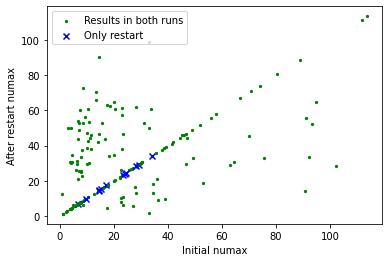

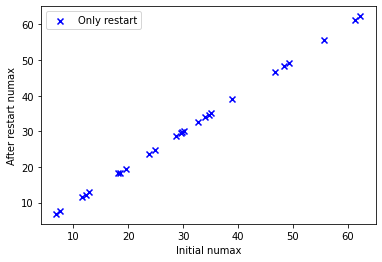

In [17]:
cases = [[psdinclude, psdstars, psdstarsrr], [lcinclude, lcstars, lcstarsrr]]
for case in cases:
    include = case[0]
    ini = case[1]
    rr = case[2]
    
    # Ugly hack
    restartlabel = False
    successlabel = False
    inilabel = False
    
    plt.figure()
    plt.xlabel('Initial numax')
    plt.ylabel('After restart numax')
    for s in include:
        if (len(np.asarray(ini[s]['numax'])[~np.isnan(ini[s]['numax'])]) > 0) & (len(rr[s]['numax']) > 0):
            if not successlabel:
                successlabel = True
                plt.scatter(ini[s]['numax'][-1], rr[s]['numax'][-1], s=5, c='g',
                            label='Results in both runs')
            else:
                plt.scatter(ini[s]['numax'][-1], rr[s]['numax'][-1], s=5, c='g')
        elif len(np.asarray(ini[s]['numax'])[~np.isnan(ini[s]['numax'])]) > 0:
            if not inilabel:
                inilabel = True
                plt.scatter(np.asarray(ini[s]['numax'])[~np.isnan(ini[s]['numax'])][-1],
                            np.asarray(ini[s]['numax'])[~np.isnan(ini[s]['numax'])][-1], marker='x', c='r',
                            label='Only initially')
            else:
                plt.scatter(np.asarray(ini[s]['numax'])[~np.isnan(ini[s]['numax'])][-1],
                            np.asarray(ini[s]['numax'])[~np.isnan(ini[s]['numax'])][-1], marker='x', c='r')
        elif len(rr[s]['numax']) > 0:
            if not restartlabel:
                restartlabel = True
                plt.scatter(rr[s]['numax'][-1], rr[s]['numax'][-1], marker='x', c='b',
                            label='Only restart')
            else:
                plt.scatter(rr[s]['numax'][-1], rr[s]['numax'][-1], marker='x', c='b')
    plt.legend()

# Make final table

In [24]:
def get_maxgoodrunstats(star):
    goodruns = [r for r in star['runs'] if star['runs'][r]['good']]
    if not goodruns:
        return {}
    maxgoodrunstats = {}
    maxgoodindex = max(r[1] for r in goodruns)
    maxgoodruns = [r for r in goodruns if r[1] == maxgoodindex]
    for run in goodruns:
        if run[1] != maxgoodindex:
            continue
        rundata = star["runs"][run]
        caseindex = run[0]
        maxgoodrunstats[caseindex] = {
            "oc_std": rundata["oc_std"]
        }
        for param_name, paramdata in rundata["params"].items():
            error = (
                np.sqrt(
                    (paramdata["hi"] - paramdata["median"]) ** 2
                    + (paramdata["median"] - paramdata["lo"]) ** 2
                )
                / np.sqrt(2)
            )
            maxgoodrunstats[caseindex].update(
                {
                    param_name: paramdata["mode"],
                    "upper_error_" + param_name: paramdata["hi"],
                    "lower_error_" + param_name: paramdata["lo"],
                    "error_" + param_name: error,
                }
            )
    return maxgoodrunstats


def combine_cases(cases):
    summarystars = {}
    for case in cases:
        for starid in case.keys():
            if len(case[starid]['runs']) == 0:
                continue
            summarystars.setdefault(starid, {'initialnumax': {}})
            summarystars[starid].setdefault('runs', {})

            summarystars[starid]['initialnumax'].update(case[starid]['initialnumax'])
            summarystars[starid]['runs'].update(case[starid]['runs'])
    return summarystars


def make_blindtable(cases, tablefile):
    summarystars = combine_cases(cases)
    initialcols = {
        "initialnumax": 'projects/corot/estimatenumax/reftable.txt',
    }
    summaryrows = get_summaryrows(summarystars, initialcols, ['4'])
    header = {
        "star": "star",
        "initialnumax": "initialnumax",
        "w4": "w",
        "upper_error_w4": "upper_credlimit_w",
        "lower_error_w4": "lower_credlimit_w",
        "error_w4": "error_w",
        "stdgran24": "stdgran2",
        "upper_error_stdgran24": "upper_credlimit_stdgran2",
        "lower_error_stdgran24": "lower_credlimit_stdgran2",
        "error_stdgran24": "error_stdgran2",
        "nugran24": "nugran2",
        "upper_error_nugran24": "upper_credlimit_nugran2",
        "lower_error_nugran24": "lower_credlimit_nugran2",
        "error_nugran24": "error_nugran2",
        "hosc4": "hosc",
        "upper_error_hosc4": "upper_credlimit_hosc",
        "lower_error_hosc4": "lower_credlimit_hosc",
        "error_hosc4": "error_hosc",
        "numax4": "numax",
        "upper_error_numax4": "upper_credlimit_numax",
        "lower_error_numax4": "lower_credlimit_numax",
        "error_numax4": "error_numax",
        "stdenv4": "stdenv",
        "upper_error_stdenv4": "upper_credlimit_stdenv",
        "lower_error_stdenv4": "lower_credlimit_stdenv",
        "error_stdenv4": "error_stdenv",
        "oc_std4": "final_oc_std",
        "previous_finalnumax": "previous_finalnumax",
        # "notes": "notes",
    }
    allkeys = set(k for r in summaryrows for k in r)
    unknown = header.keys() - allkeys
    if unknown:
        print("In header, but not in data")
        for k in header.keys():
            if k not in allkeys:
                print(k)
        print("In data, but not in header")
        for k in sorted(allkeys - header.keys()):
            print(k)
    assert not unknown, unknown
    write_csv_dicts(tablefile, header, summaryrows)


def make_summarytable(cases, tablefile):
    summarystars = combine_cases(cases)
    initialcols = {
        "initialnumax_lc": 'projects/corot/jan2022/Runs_20220124LC/CoRoT_COR_C01_G1.txt',
        "initialnumax_psd": 'projects/corot/jan2022/Runs_20220124PSD/CoRoT_COR_C01R_G1.txt',
    }
    summaryrows = get_summaryrows(summarystars, initialcols, ['1', '2'])
    header = {
        "star": "star",
        "initialnumax_lc": "initialnumax_lc",
        "w2": "w_lc",
        "upper_error_w2": "upper_credlimit_w_lc",
        "lower_error_w2": "lower_credlimit_w_lc",
        "error_w2": "error_w_lc",
        "stdgran22": "stdgran2_lc",
        "upper_error_stdgran22": "upper_credlimit_stdgran2_lc",
        "lower_error_stdgran22": "lower_credlimit_stdgran2_lc",
        "error_stdgran22": "error_stdgran2_lc",
        "nugran22": "nugran2_lc",
        "upper_error_nugran22": "upper_credlimit_nugran2_lc",
        "lower_error_nugran22": "lower_credlimit_nugran2_lc",
        "error_nugran22": "error_nugran2_lc",
        "hosc2": "hosc_lc",
        "upper_error_hosc2": "upper_credlimit_hosc_lc",
        "lower_error_hosc2": "lower_credlimit_hosc_lc",
        "error_hosc2": "error_hosc_lc",
        "numax2": "numax_lc",
        "upper_error_numax2": "upper_credlimit_numax_lc",
        "lower_error_numax2": "lower_credlimit_numax_lc",
        "error_numax2": "error_numax_lc",
        "stdenv2": "stdenv_lc",
        "upper_error_stdenv2": "upper_credlimit_stdenv_lc",
        "lower_error_stdenv2": "lower_credlimit_stdenv_lc",
        "error_stdenv2": "error_stdenv_lc",
        "oc_std2": "oc_std_lc",
        "initialnumax_psd": "initialnumax_psd",
        "w1": "w_psd",
        "upper_error_w1": "upper_credlimit_w_psd",
        "lower_error_w1": "lower_credlimit_w_psd",
        "error_w1": "error_w_psd",
        "stdgran21": "stdgran2_psd",
        "upper_error_stdgran21": "upper_credlimit_stdgran2_psd",
        "lower_error_stdgran21": "lower_credlimit_stdgran2_psd",
        "error_stdgran21": "error_stdgran2_psd",
        "nugran21": "nugran2_psd",
        "upper_error_nugran21": "upper_credlimit_nugran2_psd",
        "lower_error_nugran21": "lower_credlimit_nugran2_psd",
        "error_nugran21": "error_nugran2_psd",
        "hosc1": "hosc_psd",
        "upper_error_hosc1": "upper_credlimit_hosc_psd",
        "lower_error_hosc1": "lower_credlimit_hosc_psd",
        "error_hosc1": "error_hosc_psd",
        "numax1": "numax_psd",
        "upper_error_numax1": "upper_credlimit_numax_psd",
        "lower_error_numax1": "lower_credlimit_numax_psd",
        "error_numax1": "error_numax_psd",
        "stdenv1": "stdenv_psd",
        "upper_error_stdenv1": "upper_credlimit_stdenv_psd",
        "lower_error_stdenv1": "lower_credlimit_stdenv_psd",
        "error_stdenv1": "error_stdenv_psd",
        "oc_std1": "oc_std_psd",
        "previous_finalnumax": "previous_finalnumax",
        # "notes": "notes",
    }
    write_csv_dicts(tablefile, header, summaryrows)


def get_summaryrows(summarystars, initialcols, cases):
    summaryrows = []
    for starid in summarystars.keys():
        star = summarystars[starid]

        maxgoodrunstats = get_maxgoodrunstats(star)
        previousnumax = ''
        notes = ''

        if starid in previousstars.keys():
            if previousstars[starid]['finalnumax'] != '':
                previousnumax = previousstars[starid]['finalnumax']
            notes += previousstars[starid]['notes']

        for run in star['runs']:
            if star['runs'][run].get('notes') is not None and star['runs'][run].get('notes') != 'None':
                notes += star['runs'][run].get('notes')

        summaryrow = {
            "star": starid,
            "previous_finalnumax": previousnumax,
            "notes": notes,
        }
        for caseindex, casestats in maxgoodrunstats.items():
            for paramkey, value in casestats.items():
                summaryrow[paramkey + caseindex] = value
        for colname, filename in initialcols.items():
            summaryrow[colname] = star['initialnumax'].get(filename, '')
        summaryrows.append(summaryrow)
    return summaryrows


def write_csv_dicts(tablefile, header, summaryrows):
    summaryrows2 = [list(header.values())] + [[str(r.get(k, "")) for k in header.keys()] for r in summaryrows]
    with open(tablefile, "w") as fp:
        csv.writer(fp, delimiter="\t").writerows(summaryrows2)


In [25]:
cases = [psdstarsrr, lcstarsrr]
make_summarytable(cases, 'summarytest.csv')

In [21]:
cases = [blindstars,]
make_blindtable(cases, 'blindtest.csv')

In [19]:
# Final table
# SourceID, initialnumax(s), allnumax, finalnumaxs, decisions, notes
summarystars = {}
cases = [psdstarsrr, lcstarsrr]
for case in cases:
    for starid in case.keys():
        if len(case[starid]['runs']) == 0:
            continue
        summarystars.setdefault(starid, {'initialnumax': {}})
        summarystars[starid].setdefault('runs', {})
        
        summarystars[starid]['initialnumax'].update(case[starid]['initialnumax'])
        summarystars[starid]['runs'].update(case[starid]['runs'])
        
for starid in summarystars.keys():
    star = summarystars[starid]
    
    goodruns = [r for r in star['runs'] if star['runs'][r]['good']]
    if len(goodruns) == 0:
        star['finalnumax'] = {}
        continue
    maxgoodindex = max(r[1] for r in goodruns)
    maxgoodruns = [r for r in goodruns if r[1] == maxgoodindex]
    star["finalnumax"] = {r: star["runs"][r]["numax"] for r in maxgoodruns}
    star["finalocstd"] = {r: star["runs"][r]["oc_std"] for r in maxgoodruns}

# Do stats

In [ ]:
# Do distributions of all parameters
# Do fractional plot

# Messy

In [24]:
keys = ['star',
        'initialnumax_lc', 'initialnumax_psd',
        'finalnumax_lc', 'final_oc_std_lc',
        'finalnumax_psd', 'final_oc_std_psd',
        'previous_finalnumax',
        #'notes'
       ]
summaryrows = []
for starid in summarystars.keys():
    star = summarystars[starid]
    finalnumax_lc = ''
    finalnumax_psd = ''
    finalocstd_psd = ''
    finalocstd_lc = ''
    previousnumax = ''
    notes = ''
    for run in star['finalnumax']:
        if run[0] == '1':
            finalnumax_psd = star['finalnumax'][run]
            finalocstd_psd = star['finalocstd'][run]
        elif run[0] == '2':
            finalnumax_lc = star['finalnumax'][run]
            finalocstd_lc = star['finalocstd'][run]
        else:
            raise ValueError
            
    if starid in previousstars.keys():
        if previousstars[starid]['finalnumax'] != '':
            previousnumax = previousstars[starid]['finalnumax']
        notes += previousstars[starid]['notes']
 
    for run in star['runs']:
        if star['runs'][run].get('notes') is not None and star['runs'][run].get('notes') != 'None':
            notes += star['runs'][run].get('notes')
        
    summaryrows.append(
        {
            "star": starid,
            "initialnumax_lc": star['initialnumax'].get(
                'projects/corot/jan2022/Runs_20220124LC/CoRoT_COR_C01_G1.txt', ''),
            "initialnumax_psd": star['initialnumax'].get(
                'projects/corot/jan2022/Runs_20220124PSD/CoRoT_COR_C01R_G1.txt', ''),
            "finalnumax_lc": finalnumax_lc,
            "final_oc_std_lc": finalocstd_lc,
            "finalnumax_psd": finalnumax_psd,
            "final_oc_std_psd": finalocstd_psd,
            "previous_finalnumax": previousnumax,
            "notes": notes,
        }
    )
summaryrows2 = [keys] + [[str(r[k]) for k in keys] for r in summaryrows]
with open("summaryrun.csv", "w") as fp:
    csv.writer(fp, delimiter="\t").writerows(summaryrows2)

In [26]:
with open("summaryrun.csv", "r", newline="") as fp:
    rf = csv.reader(fp, delimiter='\t')
    print(list(rf)[0:7])

[['star', 'initialnumax_lc', 'initialnumax_psd', 'finalnumax_lc', 'final_oc_std_lc', 'finalnumax_psd', 'final_oc_std_psd', 'previous_finalnumax'], ['CRT0100402467', '19.88', '19.07', '15.02272891', '7648.088365222782', '16.69393141', '15574.381394015934', '19.96853198'], ['CRT0100408489', '3.55', '3.64', '', '', '', '', ''], ['CRT0100411979', '30.55', '28.84', '28.62447737', '6018.595615575193', '25.46980343', '7371.492329708985', '29.83215596'], ['CRT0100412751', '17.08', '15.67', '', '', '18.40648842', '12415.706115491394', '11.05973339'], ['CRT0100429067', '', '2.33', '', '', '2.093007978', '177950.49232861464', ''], ['CRT0100433798', '4.89', '7.59', '', '', '8.297346574', '8294.457996564255', '']]


In [29]:
from astropy.table import Table
summarytable = Table.read('summaryrun.csv', format='ascii.tab')
summarytable

star,initialnumax_lc,initialnumax_psd,finalnumax_lc,final_oc_std_lc,finalnumax_psd,final_oc_std_psd,previous_finalnumax
str13,float64,float64,float64,float64,float64,float64,float64
CRT0100402467,19.88,19.07,15.02272891,7648.088365222782,16.69393141,15574.381394015934,19.96853198
CRT0100408489,3.55,3.64,--,--,--,--,--
CRT0100411979,30.55,28.84,28.62447737,6018.595615575193,25.46980343,7371.492329708985,29.83215596
CRT0100412751,17.08,15.67,--,--,18.40648842,12415.706115491394,11.05973339
CRT0100429067,--,2.33,--,--,2.093007978,177950.49232861464,--
CRT0100433798,4.89,7.59,--,--,8.297346574,8294.457996564255,--
CRT0100435383,--,11.35,--,--,10.25309325,156455.119158303,--
CRT0100440069,53.69,53.45,52.25367328,1048.4925790642765,--,--,54.56163321
CRT0100440565,28.92,28.92,30.26920678,1888.772690607053,29.9624852,1877.4737235178798,29.19490464


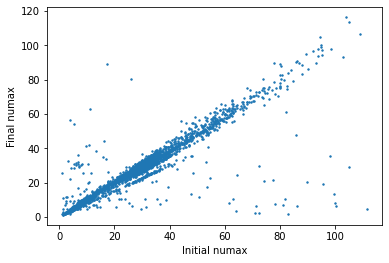

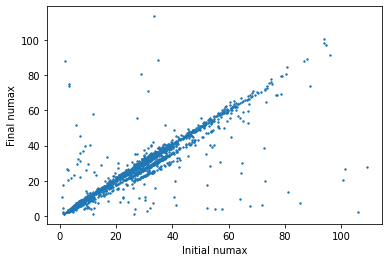

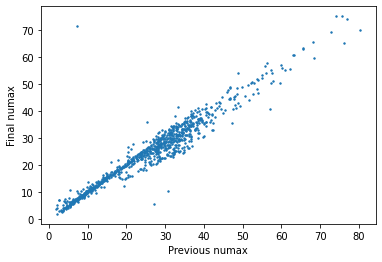

In [78]:
plt.figure()
plt.xlabel('Initial numax')
plt.ylabel('Final numax')
plt.scatter(summarytable['initialnumax_lc'], summarytable['finalnumax_lc'], s=2)

plt.figure()
plt.xlabel('Initial numax')
plt.ylabel('Final numax')
plt.scatter(summarytable['initialnumax_psd'], summarytable['finalnumax_psd'], s=2)

plt.figure()
plt.xlabel('Previous numax')
plt.ylabel('Final numax')
plt.scatter(summarytable['previous_finalnumax'], summarytable['finalnumax_lc'], s=2)

In [30]:
# Make binary table

In [89]:
from astropy.table import join

In [111]:
summarytable['star']

CRT0100402467
CRT0100408489
CRT0100411979
CRT0100412751
CRT0100429067
CRT0100433798
CRT0100435383
CRT0100440069
CRT0100440565
CRT0100441421
CRT0100442460


In [113]:
# Read in file
binarytable = Table.read(
    'projects/corot/compil_period_transits_bins_corot_MD_JD.csv',
                         format='csv')
starids = np.empty(len(binarytable['CoRoT']), dtype='U13')
for i in range(len(binarytable['CoRoT'])):
    starids[i] = 'CRT0' + str(binarytable['CoRoT'][i])
    starids = np.asarray(starids, dtype=str)
binarytable.add_column(starids, name='star')
print(binarytable['CoRoT','star'])
binarytable = join(binarytable, summarytable, keys='star')
# Compute numax from g and teff, initialise new run, run

  CoRoT        star    
--------- -------------
100569913 CRT0100569913
100766101 CRT0100766101
100836094 CRT0100836094
100871572 CRT0100871572
100889895 CRT0100889895
100998727 CRT0100998727
101063082 CRT0101063082
101437920 CRT0101437920
101536086 CRT0101536086
102361474 CRT0102361474
      ...           ...
659730961 CRT0659730961
653552892 CRT0653552892
659734617 CRT0659734617
652468775 CRT0652468775
659717815 CRT0659717815
652402971 CRT0652402971
633485847 CRT0633485847
633692945 CRT0633692945
659726146 CRT0659726146
653554004 CRT0653554004
104096141 CRT0104096141
Length = 710 rows


In [114]:
binarytable

CoRoT,Run,Epoch,e_Epoch,Per,e_Per,TABLE,star,initialnumax_lc,initialnumax_psd,finalnumax_lc,finalnumax_psd,previous_finalnumax
int64,str11,float64,float64,float64,float64,str6,str13,float64,float64,float64,float64,float64
100622251,LRc01,2454230.0,0.0060029998421669,32.3582725524902,0.00216999999247491,MT_5,CRT0100622251,9.78,12.04717066,--,--,--
100841854,LRc01,2454223.25,0.00313400011509656,17.1490116119384,0.000554999976884573,MT_5,CRT0100841854,39.27,39.43,36.87559612,38.18935724,--
100885002,LRc01,2454225.0,0.00657500000670552,11.8042116165161,0.000814000028185546,MT_5,CRT0100885002,31.37,27.59851265,31.28794233,--,--
100889895,TBF,0.0028,0.0015,0.39690017,8.4e-07,JDevor,CRT0100889895,58.58,58.42210031,--,--,--
101030167,LRc01,2454236.5,0.000622000021394342,5.13899421691894,3.79999983124434e-05,MT_5,CRT0101030167,3.09,4.147572154,--,--,--
101055792,LRc01,2454235.75,0.00290800002403557,1.93839395046234,7.000000186963e-05,MT_2,CRT0101055792,29.09,--,--,--,--
101126445,LRc01,2454219.75,0.00219399994239211,29.6633033752441,0.000664999999571591,MT_5,CRT0101126445,3.34,--,--,--,--
101206989,LRc01,2454236.25,0.0029180001001805,0.577830970287323,1.99999994947575e-05,MT_2,CRT0101206989,80.63,--,--,--,--
101248929,LRc01,2454236.75,0.00828099995851516,1.87960195541381,0.000180000002728775,MT_5,CRT0101248929,24.36,--,--,--,--


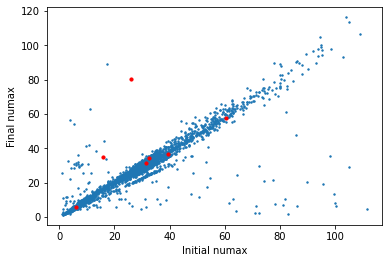

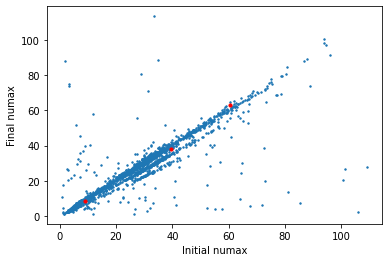

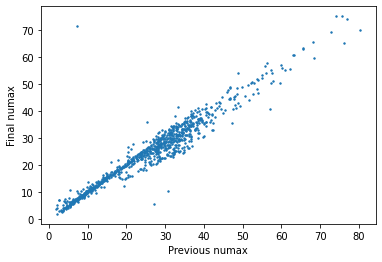

In [118]:
plt.figure()
plt.xlabel('Initial numax')
plt.ylabel('Final numax')
plt.scatter(summarytable['initialnumax_lc'], summarytable['finalnumax_lc'], s=2)
plt.scatter(binarytable['initialnumax_lc'], binarytable['finalnumax_lc'], s=10, c='r')

plt.figure()
plt.xlabel('Initial numax')
plt.ylabel('Final numax')
plt.scatter(summarytable['initialnumax_psd'], summarytable['finalnumax_psd'], s=2)
plt.scatter(binarytable['initialnumax_psd'], binarytable['finalnumax_psd'], s=10, c='r')

plt.figure()
plt.xlabel('Previous numax')
plt.ylabel('Final numax')
plt.scatter(summarytable['previous_finalnumax'], summarytable['finalnumax_lc'], s=2)
plt.scatter(binarytable['previous_finalnumax'], binarytable['finalnumax_lc'], s=10, c='r')


# Debug: Compare runs to check Backgroundtool's handling of close-to-border values

0 2210.4406625 229.8902986396892 481 689.6708959190676
1060.1720401999996 689.6708959190676
1 675.88934685 100.2107397414648 467 300.6322192243944
507.00204325827815 300.6322192243944
2 25.71997039 8.658256097520752 2978 25.974768292562256
0.0 25.974768292562256
3 2893.7118410000003 1686.2594590070291 582 5058.778377021087
1296.6695505166667 5058.778377021087
4 51.75509977 2.4355633746132006 446 7.306690123839601
6.138094083571424 7.306690123839601
5 8.7070421365 3.1935130648950203 439 9.58053919468506
5.198034232941177 9.58053919468506


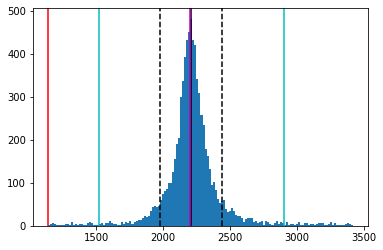

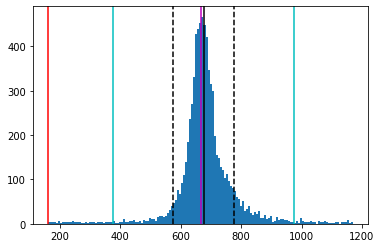

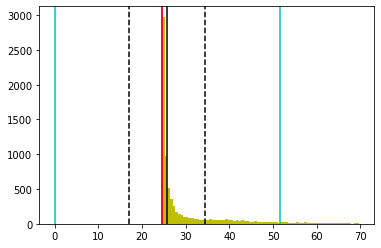

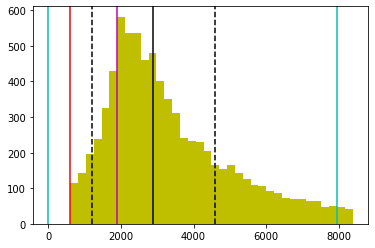

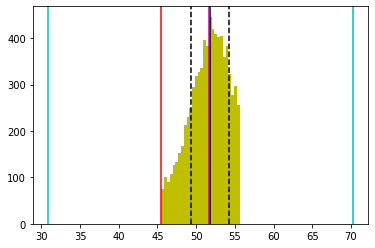

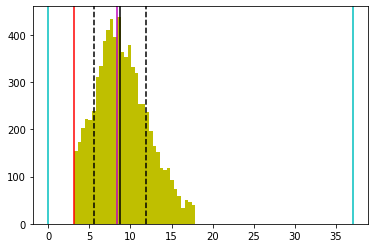

In [119]:
r = '21'
runresultdir = os.path.join('./results/CRT0101597682', r)
paramfiles = [p for p in os.listdir(runresultdir) if 'parameter0' in p]

# Human-sort list
#https://stackoverflow.com/questions/4623446/how-do-you-sort-files-numerically
paramfiles.sort(key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])

hyperparamsfile = os.path.join('./results/CRT0101597682','background_hyperParameters_' + r + '.txt')
hyperparams = np.loadtxt(hyperparamsfile, skiprows=6, unpack=True).T

new_params = []
for i, pf in enumerate(paramfiles):
    pars = np.loadtxt(os.path.join(runresultdir, pf), unpack=True)
    pmed = np.median(pars)
    pstd = np.std(pars)
    N, bin_ed = np.histogram(pars, bins='auto')

    th = (3 * pstd)
    print(i, pmed, pstd, np.amax(N), th)
    
    plt.figure()
    plt.hist(pars, bins='auto')
    plt.axvline(pmed, c='k')
    plt.axvline(pmed + pstd, c='k', ls='--')
    plt.axvline(pmed - pstd, c='k', ls='--')
    plt.axvline(bin_ed[np.argmax(N)], c='m')
    plt.axvline(np.amin(pars), c='r')

        # If we are to close to one border, we extend the parameter space 3std in that direction
    print(np.absolute(bin_ed[np.argmax(N)] - np.amin(pars)), th)
    if np.absolute(bin_ed[np.argmax(N)] - np.amin(pars)) < th:
        # Fail
        pmin = max(0, np.amin(pars) - (2 * th))
        plt.hist(pars, bins='auto', color='y')
        plt.axvline(pmin, c='c')
    else:
        pmin = max(0, pmed - th)
        plt.axvline(pmin, c='c')


    if np.amax(pars) - bin_ed[np.argmax(N)] <= th:
        # Fail
        pmax = np.amax(pars) + (2*th)
        plt.hist(pars, bins='auto', color='y')
        plt.axvline(pmax, c='c')
    else:
        pmax = pmed + th
        plt.axvline(pmax, c='c')

    if pmax - pmin > 1e4:
        line = hyperparams[i]
        newline = [line[0].astype(float),
                   line[1].astype(float)]
    else:
        newline = [pmin, pmax]
    new_params.extend(newline)

0 2205.6800155 154.0493057778196 412 231.0739586667294
658.5662049599998 231.0739586667294
1 620.4134834500001 83.48759108176255 426 125.23138662264381
234.72188664062497 125.23138662264381
2 8.359138916500001 7.687073589374146 843 11.53061038406122
7.2884222765377356 11.53061038406122
3 3597.910562 1068.0604270063623 418 1602.0906405095434
3379.3821609197057 1602.0906405095434
4 40.86467374 5.188886114339264 1224 7.783329171508896
0.0 7.783329171508896
5 19.049720360000002 4.77387447652317 434 7.160811714784756
19.854468043111915 7.160811714784756


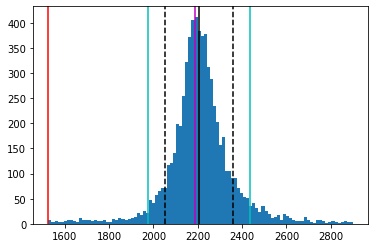

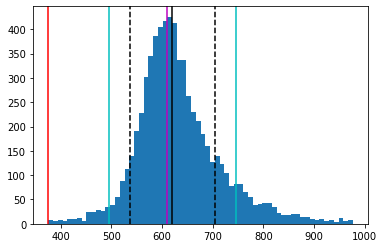

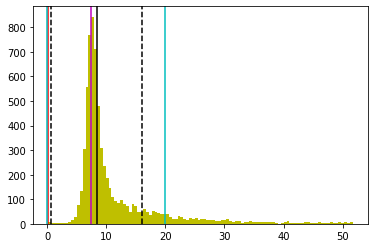

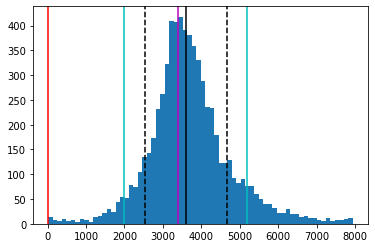

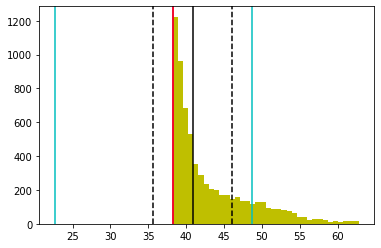

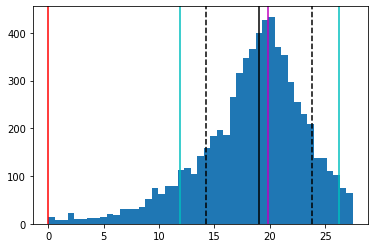

In [120]:
r = '22'
runresultdir = os.path.join('./results/CRT0101597682', r)
paramfiles = [p for p in os.listdir(runresultdir) if 'parameter0' in p]

# Human-sort list
#https://stackoverflow.com/questions/4623446/how-do-you-sort-files-numerically
paramfiles.sort(key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])

hyperparamsfile = os.path.join('./results/CRT0101597682','background_hyperParameters_' + r + '.txt')
hyperparams = np.loadtxt(hyperparamsfile, skiprows=6, unpack=True).T

new_params = []
for i, pf in enumerate(paramfiles):
    pars = np.loadtxt(os.path.join(runresultdir, pf), unpack=True)
    pmed = np.median(pars)
    pstd = np.std(pars)
    N, bin_ed = np.histogram(pars, bins='auto')

    th = (3 * pstd) / 2
    print(i, pmed, pstd, np.amax(N), th)
    
    plt.figure()
    plt.hist(pars, bins='auto')
    plt.axvline(pmed, c='k')
    plt.axvline(pmed + pstd, c='k', ls='--')
    plt.axvline(pmed - pstd, c='k', ls='--')
    plt.axvline(bin_ed[np.argmax(N)], c='m')
    plt.axvline(np.amin(pars), c='r')

    # If we are to close to one border, we extend the parameter space 3std in that direction
    print(np.absolute(bin_ed[np.argmax(N)] - np.amin(pars)), th)
    if np.absolute(bin_ed[np.argmax(N)] - np.amin(pars)) <= th:
        # Fail
        pmin = max(0, np.amin(pars) - (2 * th))
        plt.hist(pars, bins='auto', color='y')
        plt.axvline(pmin, c='c')
    else:
        pmin = max(0, pmed - th)
        plt.axvline(pmin, c='c')


    if np.amax(pars) - bin_ed[np.argmax(N)] <= th:
        # Fail
        pmax = np.amax(pars) + (2 * th)
        plt.hist(pars, bins='auto', color='y')
        plt.axvline(pmax, c='c')
    else:
        pmax = pmed + th
        plt.axvline(pmax, c='c')

    if pmax - pmin > 1e4:
        line = hyperparams[i]
        newline = [line[0].astype(float),
                   line[1].astype(float)]
    else:
        newline = [pmin, pmax]
    new_params.extend(newline)
